In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)
sfh = sfh_all.query('year == 2004')
dogs = pd.read_csv('data/akc.csv').dropna()

b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


In [4]:
should_clear = ['bingroup']

def clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def clear_props(traces):
    for trace in traces:
        for prop in should_clear:
            clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = next(left.select_traces())
    t2 = next(right.select_traces())
    clear_props([t1, t2])
    fig.add_trace(t1, row=1, col=1)
    fig.add_trace(t2, row=1, col=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

(ch:viz_scale)=
# Choosing Scale to Reveal Structure


In {numref}`Chapter %s <ch:eda>`, we explored prices for houses sold in the San Francisico Bay Area between 2003 and 2009. Let's revisit that example and take a look at a histogram of sale prices.

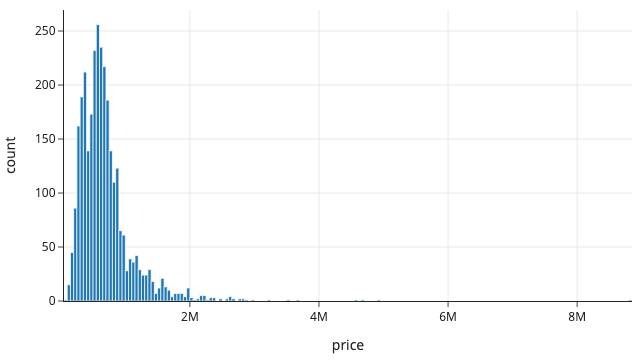

In [5]:
px.histogram(sfh, x='price', width=350, height=250)

While this plot accurately displays the data,
most of the data are crammed into the left side of the plot.
This makes it hard to understand the distribution of prices.

Through data visualization, we want to reveal important features of the data
like the shape of a distribution and the relationship between two or more features. 
As this example shows, after we produce an initial plot there are still other aspects we need to consider.
In this section, we cover *principles of scale* which help us decide how to
adjust the axis limits, place tick marks, and apply transformations. 
We begin by examining when and how we might adjust a plot to reduce empty space; in other words we try to fill the data region of our plot with data.

## Filling the Data Region

As we can see from the histogram of sale prices, it's hard to read
a distribution when
most of the data appear in a small portion of the plotting region.
When this happens, important features of the data can be obscured like
multiple modes and skewness.
A similar issue happens for scatter plots. 
When all the points are bunched together in the corner of a scatter plot, it's hard to shape, such as the form of nonlinearity.

This issue can crop up when there are a few unusually large observations.
In order to get a better view of the main portion
of the data we can drop those observations from the plot by adjusting the
x- or y-axis limits, or by removing outlier values from the data before
plotting.
In either case, we mention this exclusion in
the caption or on the plot itself.

Let's use this idea to improve the histogram of house prices.
In the side-by-side plots below, we clip the data by changing the limits of the x-axis. 
On the left, we've excluded houses that cost over $\$2,000,000$. 
The shape of the distribution for the bulk of the houses is much clearer in this plot.
For instance, we can more easily observe the skewness and a smaller secondary mode.
On the right, we separately show detail in the long right tail of the distribution.

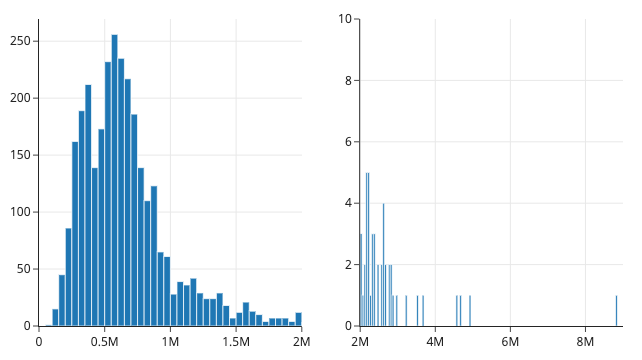

In [26]:
right_hist = px.histogram(sfh, x='price')
left_hist = px.histogram(sfh, x='price')
fig = left_right(left_hist, right_hist, height=250)
fig.update_xaxes(range=[0, 2e6], row=1, col=1)
fig.update_xaxes(range=[2e6, 9e6], row=1, col=2)
fig.update_yaxes(range=[0, 10], row=1, col=2)
fig

We addressed the issue of scale in the original histogram of housing prices by making two plots, one for the bulk of the data and one for the tail. By choosing useful x- and y-axis limits for both plots, we can show additional
useful information about the distribution. 

Notice that the x-axis in the left plot includes 0, but the x-axis in the right plot begins at \$2,000,000. We consider when to include or exclude 0 on an axis next. 

## Including Zero

We often don't need to include 0 on an axis, especially if including it makes it difficult to fill the data region. For instance, the scatter plot below shows the average longevity plotted
against average height for dog breeds. (This dataset was first introduced in {numref}'Chapter %s <ch:eda>'; it includes several features for 172 breeds.)
The x-axis of the plot starts at 10 cm since all dogs are at least that tall, and, similarly, the y-axis begins at 5 years.

In [27]:
fig = px.scatter(dogs, x='height', y='longevity',
                 title='Longevity vs. height for dog breeds',
                 width=350, height=250)

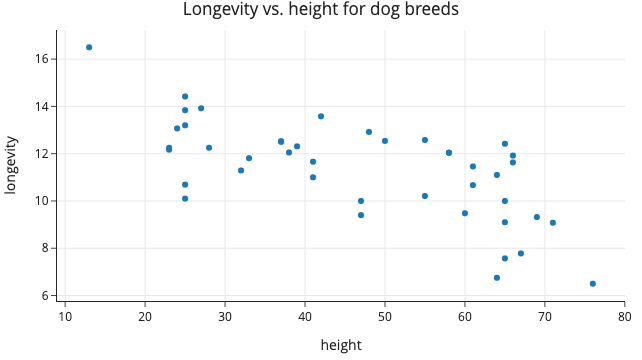

In [28]:
margin(fig, t=30)
fig.show()

There are a few cases where we usually want to include 0.
For bar charts, including 0 is important so the heights of the bars directly relate to the data values.
As an example, below, we've created two bar charts that compare the longevity of dog breeds. 
The left plot includes 0, but the right plot doesn't. It's easy to incorrectly conclude from the right
plot that medium-sized dogs live twice as long as large-sized dogs.

In [30]:
dogs_lon = dogs.groupby('size')['longevity'].mean().reset_index()
sml = {"size": ['small', 'medium', 'large']}

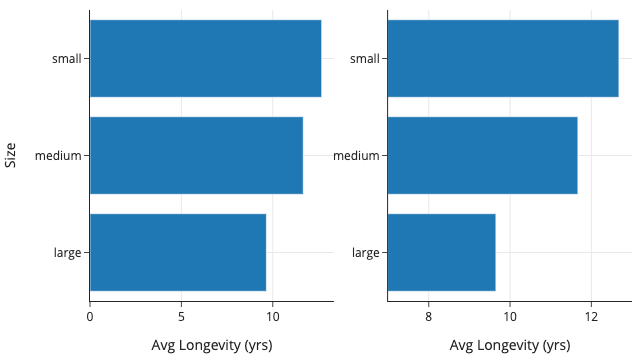

In [32]:
left = px.bar(dogs_lon, x='longevity', y='size', category_orders=sml)
right = px.bar(dogs_lon, x='longevity', y='size', category_orders=sml)
fig = left_right(left, right, height=250)
fig.update_xaxes(range=[7, 13], row=1, col=2)
fig.update_xaxes(title_text='Avg Longevity (yrs)')
fig.update_layout(yaxis_title="Size")
fig.show()

We also typically want to include zero when working with proportions, since
proportions range from 0 to 1.
The plot below shows the proportion of breeds in each type.

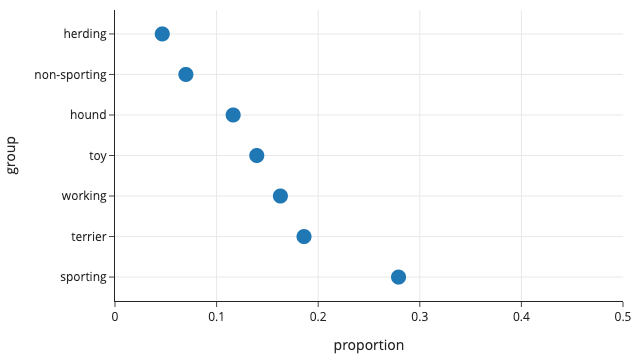

In [50]:
size_props = ((dogs['group'].value_counts() / len(dogs))
              .reset_index()
              .rename(columns={'index': 'group', 'group': 'proportion'}))

size_props
fig = px.scatter(size_props, x='proportion', y='group',
                 width=350, height=250)
fig.update_traces(marker_size=15)
fig.update_xaxes(range=[0, 0.5])

In both the bar and dot plots, by including 0, we make it easier for our reader to accurately compare the relative sizes of the categories.  

Earlier, when we adjusted axes, we essentially dropped data from our plotting region. While this is a useful strategy when a handful of observations are unusually large (or small), it is less effective with skewed distributions. In this situation, we often need to transform the data to gain a better view of its shape.  

## Revealing Shape Through Transformations

Another common way to adjust scale is to transform the data or the plot's axes. 
We use transformations for skewed data so that it is easier to inspect the distribution.
And, when the transformation produces a symmetric distribution, the symmetry carries with it useful properties for modeling (see {numref}`Chapter %s <ch:linear>`.

There are multiple ways to transform data, but the log-transform tends to be especially useful.
For instance, we've reproduced two histograms of SF house sale prices below.
The left histogram is the original data.
On the right, we've taken the log (base 10) of the prices before plotting.

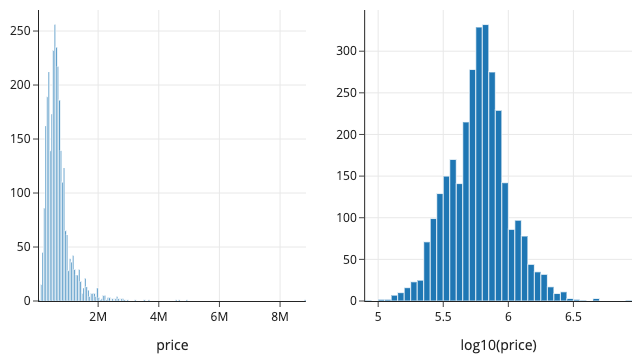

In [34]:
sfl = sfh.assign(log_price=np.log10(sfh['price']))

orig = px.histogram(sfl, x='price', width=350, height=250)
logged = px.histogram(sfl, x='log_price',
                      nbins=100,
                      labels=dict(log_price='log10(price)'),
                      width=350, height=250)

fig = left_right(orig, logged)
fig.update_xaxes(title_text='price', row=1, col=1)
fig.update_xaxes(title_text='log10(price)', row=1, col=2)

The log transformation makes the distribution of prices more symmetric.
Now, we can more easily see important features of the distribution, like
the mode at around $10^{5.85}$ which is about 700,000 and the secondary mode
near $10^{5.55}$ or 350,000.

The downside of using the log transform is that the actual values aren't
as intuitive---in this example, we needed to convert the values back to
original dollars to understand the sale price. Instead, we often favor transforming the axis to a log scale. This way we can see the original values on the axis, as shown below.

In [40]:
fig = px.histogram(sfh, x='price',
                   log_x=True,
                   histnorm='probability density',
                   width=350, height=250)

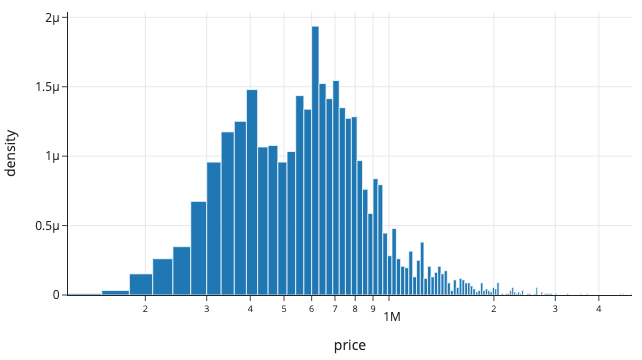

In [42]:
fig.update_traces(xbins_size=30_000)
fig.update_yaxes(title="density")
fig.show()

The above histogram with its log scaled x-axis essentially shows the same shape as the histogram of the transformed data.
But, since the axis is displayed in the original units, we can directly
read off the location of the modes in dollars.

The log transform can also reveal shape in scatter plots.
Below, we've plotted building size on the x-axis and
the lot size on the y-axis.
It's hard to see the shape in this plot since many of the points are crammed
along the bottom of the data region.

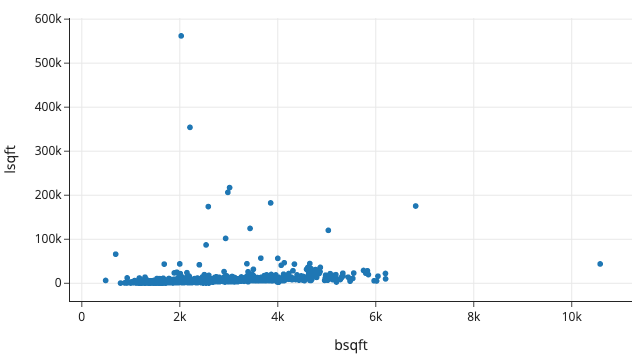

In [46]:
px.scatter(sfh, x='bsqft', y='lsqft', 
          width=350, height=250)

However,when we use a log scale for both x- and y-axes, the shape of the relationship is much easier to see.

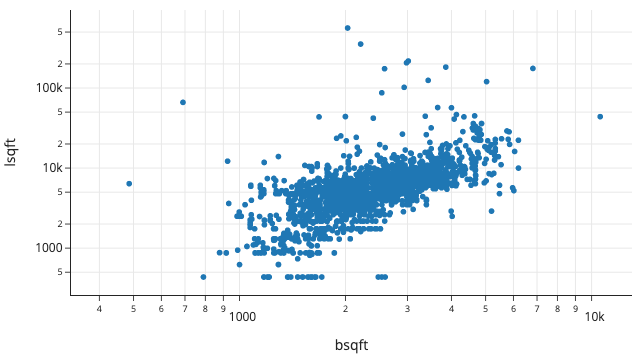

In [47]:
px.scatter(sfh, x='bsqft', y='lsqft',
           log_x=True, log_y=True, width=350, height=250)

With the transformed axes, we can see that the lot size increases roughly linearly with building size (on the log scale). The log transformation pulls large values--values that are orders of magnitude larger than others--in toward the center. This transformation can help fill the data region and uncover hidden structure as we saw for both the distribution of house price and the relationship between house size and lot size. 

In addition to setting the limits of an axis and transforming an axis, we also want to consider the aspect ratio of the plot--the length compared to the width. Adjusting the aspect ration is called "banking", and in the next section, we show how banking can help reveal relationships between features.  

## Banking to Decipher Relationships

With scatterplots, we try to choose scales so that the relationship between the two features roughly follows a
45-degree line. This scaling is called "banking to 45 degrees."
It makes it easier to see shape and trends because our eyes can more easily pick up deviations from a line this way.
Our eyes can better detect departures from a straight line when the data roughly fall along a 45-degree angle.
For instance, we've reproduced the plot that shows longevity of dog breeds against height.
The plot has been banked to 45 degrees, and we can more easily
see how the data roughly follow a line and where they deviate a bit at the extremes.

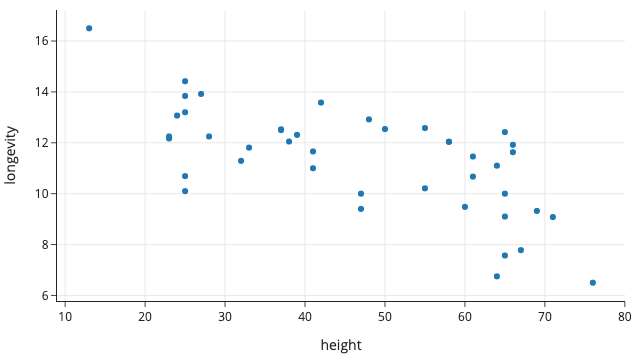

In [48]:
px.scatter(dogs, x='height', y='longevity',
                 width=300, height=300)

While banking to 45 degrees helps us see whether or not the data follow a linear relationship, when there is clear curvature we often find it hard to figure out the form of the nonlinear relationship. When this happens, we try transformations of features to get the data to fall along a straight line.
We saw earlier that when we examining highly skewed data, the log transformation is often preferable to simply changing the scale of the x-axis. The log transformation can also be useful in uncovering the general form of curvilinear relationships.

## Revealing Relationships Through Straightening

We often use scatter plots to look at the relationship between two variables.
For instance, in the plot below we've plotted height against weight
for the dog breeds. We see that taller dogs weigh more, but this relationship isn't linear.

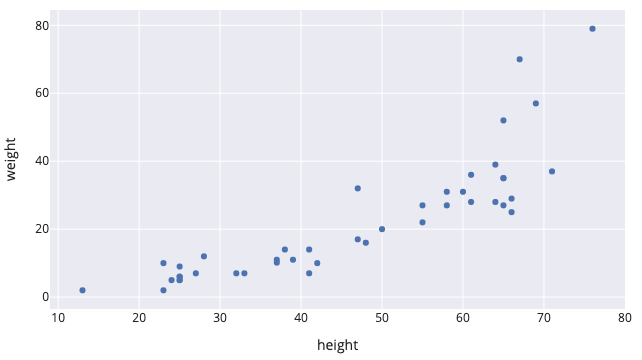

In [14]:
px.scatter(dogs, x='height', y='weight',
           width=350, height=250)

When it looks like two variables have a non-linear relationship, it's useful
to try applying a log scale the x-axis, y-axis, or both.
We look for a linear relationship in the scatter plot with transformed axes.
For instance, in the plot below, we applied a log scale to both x- and y-axes.

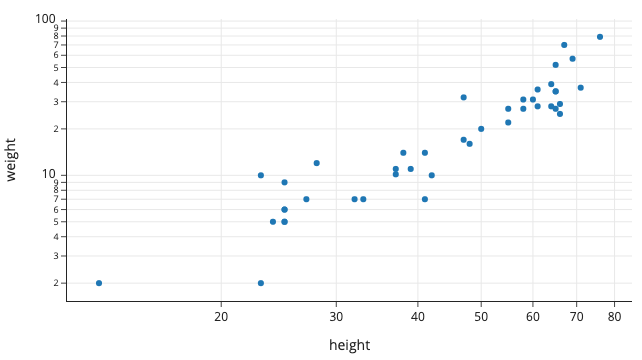

In [49]:
px.scatter(dogs, x='height', y='weight',
           log_x=True, log_y=True, width=350, height=350)

This plot shows a roughly linear relationship when both axes are on a log scale.
In this case, we can say that there's a power-law relationship between dog height and weight.
This makes sense intuitively---if a dog is taller,  then it's probably proportionally both longer and wider so we might expect that the weight of a dog has a cubic relationship with its height.


In general, when we see a linear relationship after transforming one or both axes, we can use
{numref}`Table %s <tab:transform-rels>` to reveal what relationship the original variables have.
We make these transformations because it is easier for us to see whether points fall along a line or not than to see if they follow a power law rather than an exponential curve.  

:::{table} Relationships between two variables when transformations are applied. $a$ and $b$ are constants.
:name: tab:transform-rels


| x-axis         | y-axis         | Relationship                | AKA 
| :------------- | :------------- | :-------------------------- |:-------- 
| No transform   | No transform   | Linear: $ y = ax + b $      | Linear     
| Log-scale      | No transform   | Log: $ y = a \log x + b $   | Linear-Log 
| No transform   | Log-scale      | Exponential: $ y = ba^x $   | Log-Linear 
| Log-scale      | Log-scale      | Power: $ y = bx^a $         | Log-Log    


:::

As {numref}`Table %s <tab:transform-rels>` shows, 
the log transform can reveal several common types of relationships.
Because of this, the log transform is considered the jackknife of 
transformations.
As another, albeit
artificial, example, the leftmost plot in
{numref}`Figure %s <example-transforms>`
reveals a curvilinear
relationship between x and y. The middle plot show a different curvilinear
relationship between log(y) and x; this plot also appears nonlinear. A
further log transformation, at the far right in the figure, displays a plot of
log(y) against log(x). This plot confirms that the data have a log-log (or power)
relationship because the transformed points fall along a line.

```{figure} figures/example-transforms.png
---
name: example-transforms
---

These scatter plots show how log transforms can "straighten" a curvilinear
relationship between two variables. The same (x,y) pairs are used to make  each plot, but the middle plot shows (x, log y) and the right plot (log x, log y). 
```

Adjusting scale is an important practice in data visualization, and in this section, we showed several approaches and when each approach is useful. When the data have a few unusually large values, we can clip the axis limits to "drop" these points and zoom in on the bulk of the data.
Another approach to filling the data region when the data are highly skewed is to apply a log transformation. 
These transformations can help reveal features that are otherwise not apparent in the untransformed graphs. The log transformation is a very useful tool for uncovering the shape of a distribution and the form of a relationship. When we straighten a curve by using a log transformation on one or both axes, we can better assess the form of the original nonlinear relationship.  And, changing the length and width of a scatter plot so that the data bank to 45 degrees helps us see curvature.   
 
In the next section, we look at principles of smoothing which we use 
when we need to visualize lots of data.